<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/img_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movement and deformation analysis from images

##Principles

*   Images/videos are made by a stabil camera (camera not moving during observations)
*   Calibrated camera/system necessary
*   Image resolution is echanced by geodetic telescope


##Methods

*   Template matching
*   Patern recognition

###Template matching characteristics

Pros

*   There is always a match
*   Simple algorithm
*   No special marker neccesary

Contras

*   The chance of false match is higher
*   No or minimal rotation
*   No or minimal scale change

###Pattern recognition charasteristics

Pros

*   Marker can rotate
*   Marker scale can change
*   Normal of the marker can be estimated

Contras


*   Special marker have to fit to target
*   More sensitive for light conditions


##Template matching

In [19]:
!wget -O sample_data/mona_temp4.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/mona_temp4.png
!wget -O sample_data/monalisa.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa.jpg

--2022-03-12 13:51:07--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/mona_temp4.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9199 (9.0K) [image/png]
Saving to: ‘sample_data/mona_temp4.png’

sample_data/mona_te 100%[===================>]   8.98K  --.-KB/s    in 0s      

2022-03-12 13:51:08 (51.4 MB/s) - ‘sample_data/mona_temp4.png’ saved [9199/9199]

--2022-03-12 13:51:08--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP requ

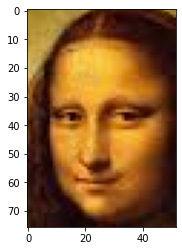

In [20]:
import cv2
import matplotlib.pyplot as plt
templ = cv2.imread('sample_data/mona_temp4.png')      # load template
templ_gray = cv2.cvtColor(templ, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(templ, cv2.COLOR_BGR2RGB))    # BGR vs. RGB

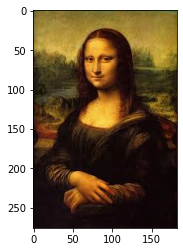

In [21]:
img = cv2.imread('sample_data/monalisa.jpg')    # load image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

best match at (57, 25) value 0.999999


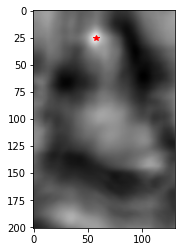

In [23]:
result = cv2.matchTemplate(img_gray, templ_gray, cv2.TM_CCOEFF_NORMED)
#result.shape, img_gray.shape
import numpy as np
result_uint = ((result - np.min(result)) / (np.max(result) - np.min(result)) * 256).astype('uint8')
result_img = cv2.cvtColor(result_uint, cv2.COLOR_GRAY2BGR)
plt.imshow(result_img)
val, _, max = cv2.minMaxLoc(result)[1:4]
plt.plot([max[0]],[max[1]], 'r*')
print(f'best match at {max} value {val:.6f}')


###Homography matrix

If the pattern is on a rotated, scaled plain probably the pattern won't match the image. We can help this case using projectiv transformation and homology matrix. (source: https://github.com/jephraim-manansala/object-detection/blob/master/Object%20Detection%20using%20Template%20Matching.ipynb)

In [5]:
!wget -O sample_data/monalisa_tilt.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa_tilt.jpg

--2022-03-12 13:41:13--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa_tilt.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136655 (133K) [image/jpeg]
Saving to: ‘sample_data/monalisa_tilt.jpg’

sample_data/monalis 100%[===================>] 133.45K  --.-KB/s    in 0.04s   

2022-03-12 13:41:13 (3.72 MB/s) - ‘sample_data/monalisa_tilt.jpg’ saved [136655/136655]



best match at (467, 240) value 0.574015


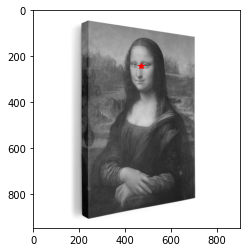

In [37]:
img = cv2.imread('sample_data/monalisa_tilt.jpg', cv2.IMREAD_GRAYSCALE)
result = cv2.matchTemplate(img, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
print(f'best match at {max} value {val:.6f}')
plt.imshow(img, cmap="gray")
_ = plt.plot([max[0]],[max[1]], 'r*')

In [31]:
from skimage import transform

def project_planes(image, src, dst):
    """ calculate transformation matrix """
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]

    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]
    
    fig, ax = plt.subplots(1,2, figsize=(13,8))
    
    new_image = image.copy() 
    projection = np.zeros_like(new_image)

    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(image, tform.inverse)
    
    ax[0].imshow(new_image, cmap="gray");
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(transformed, cmap="gray")
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Warped Image')
    plt.tight_layout()
    return transformed

error: ignored

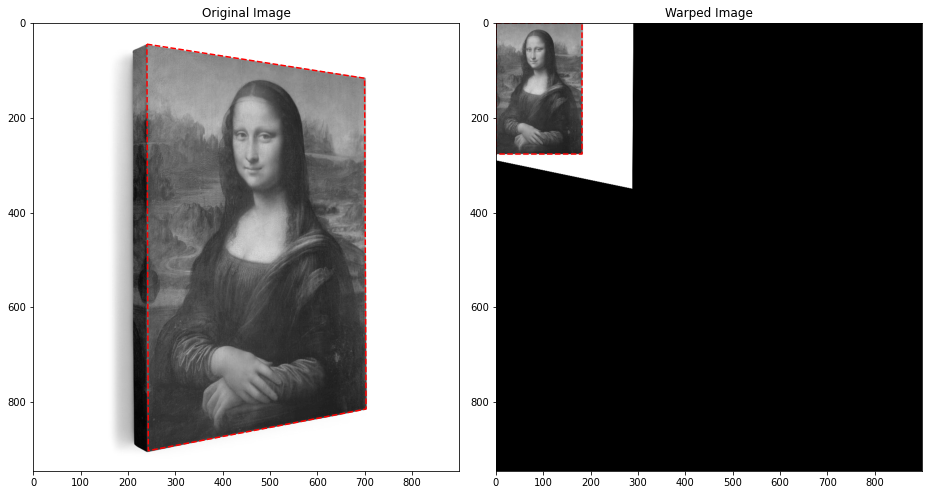

In [43]:
src = [(240, 44), (700, 116), (703, 815), (243, 903)]
dst = [(0, 0), (182, 0), (182, 276), (0,276)]
img_dst = project_planes(img, src, dst)[0:182, 0:276]
img_dst.shape
#result = cv2.matchTemplate(img_dst, templ_gray, cv2.TM_CCOEFF_NORMED)
#val, _, max = cv2.minMaxLoc(result)[1:4]
#print(f'best match at {max} value {val:.6f}')
#plt.imshow(img, cmap="gray")
#_ = plt.plot([max[0]],[max[1]], 'r*')



##Recognition of ArUco markers

"An ArUco marker is a synthetic square marker composed by a wide black border and an inner binary matrix which determines its identifier (id). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. The marker size determines the size of the internal matrix. For instance a marker size of 4x4 is composed by 16 bits." (*from OpenCV documentation*)

There is a library in OpenCV to detect ArUco markers what we have to import.

--2022-03-12 13:41:13--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/markers.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2694 (2.6K) [image/png]
Saving to: ‘sample_data/markers.png’

sample_data/markers 100%[===================>]   2.63K  --.-KB/s    in 0s      

2022-03-12 13:41:13 (28.7 MB/s) - ‘sample_data/markers.png’ saved [2694/2694]



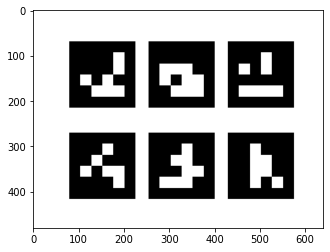

In [6]:
from cv2 import aruco
!wget -O sample_data/markers.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/markers.png
img = cv2.imread('sample_data/markers.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

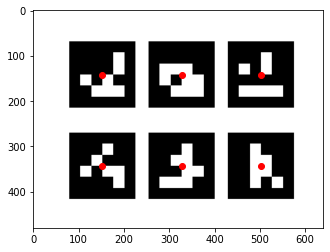

In [7]:
aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
params = aruco.DetectorParameters_create()
corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
x = np.zeros(ids.size)
y = np.zeros(ids.size)
for j in range(ids.size):
  x[j] = int(round(np.average(corners[j][0][:, 0])))
  y[j] = int(round(np.average(corners[j][0][:, 1])))
plt.imshow(img)
plt.plot(x, y, "ro")



##Complex example

We have a video of a moving object with an ArUco marker. Let's process the video frame by frame and make a plot.



In [8]:
!wget -O sample_data/demo.mp4 https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4

--2022-03-12 13:41:14--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6885075 (6.6M) [application/octet-stream]
Saving to: ‘sample_data/demo.mp4’

sample_data/demo.mp 100%[===================>]   6.57M  --.-KB/s    in 0.1s    

2022-03-12 13:41:14 (65.3 MB/s) - ‘sample_data/demo.mp4’ saved [6885075/6885075]



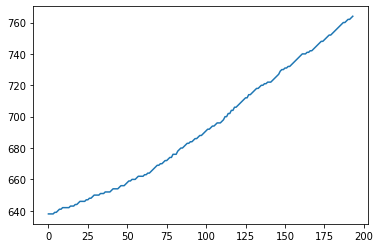

In [9]:
cap = cv2.VideoCapture('sample_data/demo.mp4')
frame = 0                 # frame counter
xc = []                   # for pixel coordinates of marker
yc = []
frames = []
while True:
  ret, img = cap.read()   # get next frame from video
  if ret:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
    if ids:
      xc.append(int(round(np.average(corners[0][0][:, 0]))))
      yc.append(img_gray.shape[1] - int(round(np.average(corners[0][0][:, 1]))))  # change y direction
      frames.append(frame)
    frame += 1
  else:
    break       # no more images
plt.plot(frames, yc)

##Calibration

Low-cost cameras have significant distortions (radial and tangetial). We have to calibrate cameras before using deformation and movement analysis.

###Radial distortion

$$ x' = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$
$$ y' = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$

###Tangential distortion

$$ x' = x + (2 p_1 x y + p_2 (r^2 + 2 x^2)) $$
$$ y' = y + (p_1 (r^2+2 y^2) + 2 p_2 x y) $$

###Camera matrix

<table>
<tr><td>f<sub>x</sub></td><td>0</td><td>c<sub>x</sub></td></tr>
<tr><td>0</td><td>f<sub>y</sub></td><td>c<sub>y</sub></td></tr>
<tr><td>0</td><td>0</td><td>1</td></tr>

For the calibration we need a chessboard like figure and more than ten photos from different directions.

Let's download first the images.

In [15]:
!wget -O sample_data/cal.zip https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/cal.zip
!unzip -o sample_data/cal.zip -d sample_data

--2022-03-12 13:44:27--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/cal.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56602854 (54M) [application/zip]
Saving to: ‘sample_data/cal.zip’

sample_data/cal.zip 100%[===================>]  53.98M   134MB/s    in 0.4s    

2022-03-12 13:44:27 (134 MB/s) - ‘sample_data/cal.zip’ saved [56602854/56602854]

Archive:  sample_data/cal.zip
  inflating: sample_data/cal1.jpg    
  inflating: sample_data/cal2.jpg    
  inflating: sample_data/cal3.jpg    
  inflating: sample_data/cal4.jpg    
  inflating: sample_data/cal5.jpg    
  inflating: sample_data/cal6.jpg    
  inflating: sample_data/cal7.jpg    
  inflating: sample_data/cal8.jpg    
  inflating: sample_data/cal9.jpg

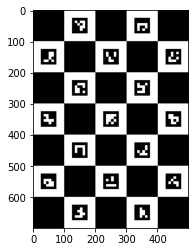

In [11]:
import glob

width = 5       # Charuco board size
height = 7
board = cv2.aruco.CharucoBoard_create(width, height, .025, .0125, aruco_dict)   # generate board in memory
img = board.draw((500, 700))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [12]:
allCorners = []
allIds = []
decimator = 0

for name in glob.glob("sample_data/cal*.jpg"):
  frame = cv2.imread(name)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict)
  ret, corners1, ids1 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
  allCorners.append(corners1)
  allIds.append(ids1)
  decimator += 1

ret, mtx, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(allCorners, allIds, board, gray.shape, None, None)
print("Camera matrix [pixels]")
for i in range(mtx.shape[0]):
  print(f'{mtx[i][0]:8.1f} {mtx[i][1]:8.1f} {mtx[i][2]:8.1f}')
print('Radial components')
print(30 * '-')
print(f'{dist[0][0]:10.5f} {dist[0][1]:10.5f} {dist[0][2]:10.5f}')
print(30 * '-')
print('Tangential components')
print(f'{dist[0][3]:10.5f} {dist[0][4]:10.5f}')

Camera matrix [pixels]
 28024.8      0.0   1379.3
     0.0  26853.3   1486.8
     0.0      0.0      1.0
Radial components
------------------------------
  74.78224  -31.09830    0.67543
------------------------------
Tangential components
  -0.58000   -0.10764


Distorted image

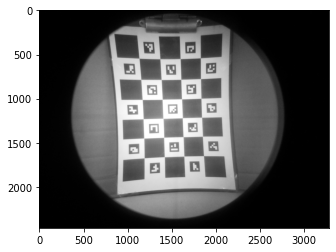

In [13]:
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))


Undistored image, corrected by calibration parameters

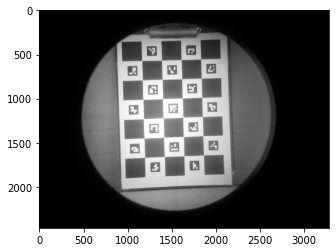

In [14]:
plt.imshow(cv2.cvtColor(cv2.undistort(gray, mtx, dist, None), cv2.COLOR_BGR2RGB))

##Tasks


*   Try to use both methods with your own images
*   Blur the images (monalisa.jpg, markers.png) and try to use both methods
* Modify the code of the complex example to use template matching method
* In the complex example try to change pixels to mm and frames to seconds (video has 2 fps, the size of the marker is 6.5 cm).
* Calibrate the camera of your mobile
